# Exponential weighting analysis for GAT and GIN

This notebook explores two trained GNN architectures, the GAT and GIN, on the D4 receptor chemical docking regression task. Specifically, we look at the following visualizations:
1. Regression scatter plots (threshold based and weight based)
2. Regression detection heatmaps
3. Selection threshold vs AUROC
4. Selection threshold vs F1

In each instance, we compare the results of the model when using different forms of exponential label weighing in order to evaluate the percision/recall effects of such scaling. 

## 1. GAT model

We first explore the Graph Attention Model (https://arxiv.org/abs/1710.10903). In all three cases, the model was trained based on early stopping heuristics. Though formal hyperparameter search has not been conducted, each model is trained to reasonable convergence values. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24, 6]
from sklearn.metrics import f1_score

In [2]:
# Read and format relevant data
df_true_nw = pd.read_csv("../outputs/GATREGv0.1_exp0_labels.csv", header=None)
df_pred_nw = pd.read_csv("../outputs/GATREGv0.1_exp0_preds.csv", header=None)

df_true_exp1 = pd.read_csv("../outputs/GATREGv0.1_exp1.0_labels.csv", header=None)
df_pred_exp1 = pd.read_csv("../outputs/GATREGv0.1_exp1.0_preds.csv", header=None)

df_true_exp2 = pd.read_csv("../outputs/GATREGv0.1_exp1.5_labels.csv", header=None)
df_pred_exp2 = pd.read_csv("../outputs/GATREGv0.1_exp1.5_preds.csv", header=None)

df_true_nw = np.array(df_true_nw).flatten()
df_pred_nw = np.array(df_pred_nw).flatten()

df_true_exp1 = np.array(df_true_exp1).flatten()
df_pred_exp1 = np.array(df_pred_exp1).flatten()

df_true_exp2 = np.array(df_true_exp2).flatten()
df_pred_exp2 = np.array(df_pred_exp2).flatten()

print(df_true_nw.dtype, df_true_nw.shape)
print(df_pred_nw.dtype, df_pred_nw.shape)

print(df_true_exp1.dtype, df_true_exp1.shape)
print(df_pred_exp1.dtype, df_pred_exp1.shape)

print(df_true_exp2.dtype, df_true_exp2.shape)
print(df_pred_exp2.dtype, df_pred_exp2.shape)

float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)


(-4.0, 10.0)

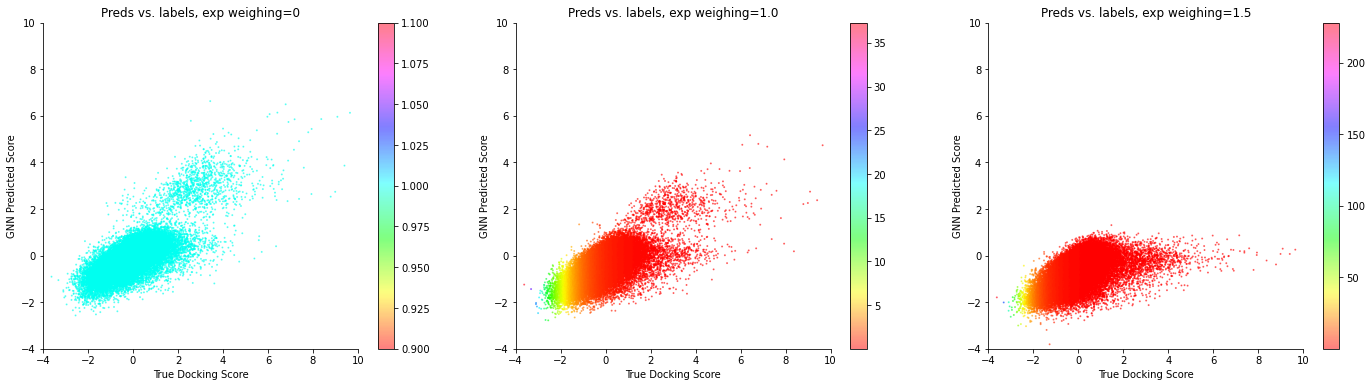

In [3]:
# Plot preds vs true labels

# no weighing 
plt.subplot(1, 3, 1)
plt.scatter(df_true_nw, df_pred_nw, s=1, alpha=0.5, c=np.ones((df_true_nw.shape)), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.0
plt.subplot(1, 3, 2)
plt.scatter(df_true_exp1, df_pred_exp1, s=1, alpha=0.5, c=np.exp(-1*df_true_exp1), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.5
plt.subplot(1, 3, 3)
plt.scatter(df_true_exp2, df_pred_exp2, s=1, alpha=0.5, c=np.exp(-1.5*df_true_exp2), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.5")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

(-4.0, 10.0)

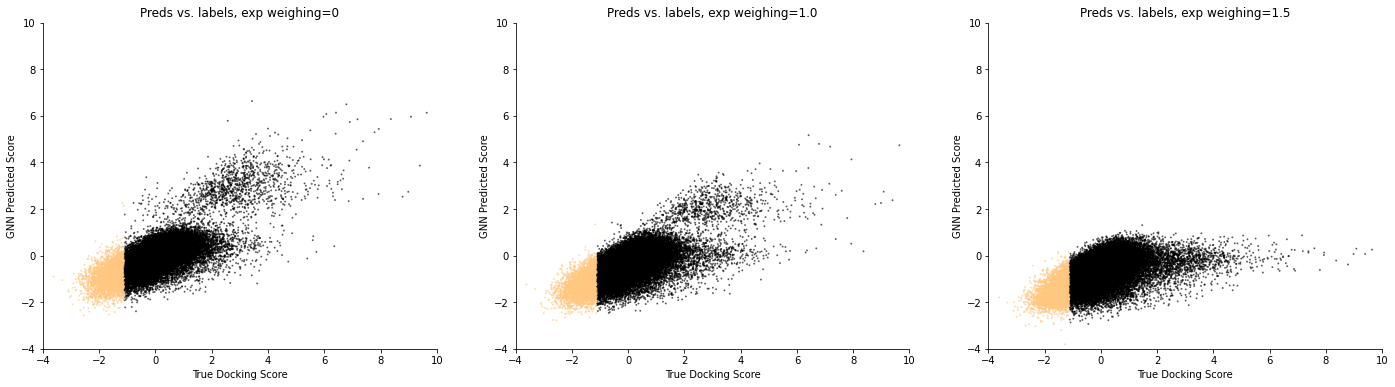

In [4]:
# Replot scatter plots but with hard threshold coloring
threshold_color_pct = 10
threshold_color = np.sort(df_true_nw)[int(df_true_nw.shape[0]/threshold_color_pct)]

f_nw = df_true_nw

# no weighing
plt.subplot(1, 3, 1)
plt.scatter(df_true_nw, df_pred_nw, s=1, alpha=0.5, c=(df_true_nw < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.0
plt.subplot(1, 3, 2)
plt.scatter(df_true_exp1, df_pred_exp1, s=1, alpha=0.5, c=(df_true_exp1 < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.5
plt.subplot(1, 3, 3)
plt.scatter(df_true_exp2, df_pred_exp2, s=1, alpha=0.5, c=(df_true_exp1 < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.5")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

In [5]:
# Regression detection heat maps -- TODO: clean code


"""Main module."""
import matplotlib.pyplot as plt
import numpy as np


def erf(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return len(
        set(indexs_pred[:int(r * indexs_pred.shape[0])]).intersection(set(indexs_true[:int(y * indexs_pred.shape[0])])))


def erfmax(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return (int(min(r, y) * indexs_pred.shape[0]))


def nefr(*i):
    return erf(*i) / erfmax(*i)


def nefrcurve(points_, p, t, min_sample=-3, reverse_sort=False):
    xs = np.logspace(min_sample, 0, points_, base=10)
    ys = np.logspace(min_sample, 0, points_, base=10)

    indexs_pred = np.argsort(p)
    indexs_true = np.argsort(t)
    if reverse_sort:
        indexs_pred = indexs_pred[::-1]
        indexs_true = indexs_true[::-1]

    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros(xx.shape)
    for i in range(points_):
        for j in range(points_):
            zz[i, j] = nefr(p, t, xx[i, j], yy[i, j], indexs_pred, indexs_true)

    return xx, yy, zz


class RegressionEnrichmentSurface:

    def __init__(self, percent_min=-3):
        self.min = percent_min
        self.nefr = None
        self.stratify = False

    def compute(self, trues, preds, stratify=None, samples=30):
        self.stratify = stratify is not None
        self.samples = samples
        if not self.stratify:
            self.nefr = nefrcurve(samples, preds, trues, self.min)
        else:
            x, y, z = [], [], []
            u, indices = np.unique(stratify, return_inverse=True)
            for i in (range(u.shape[0])):
                locs = np.argwhere(indices == i).flatten()
                preds_strat = preds[locs]
                trues_strat = trues[locs]
                try:
                    x_2, y_2, z_2 = nefrcurve(samples, preds_strat, trues_strat)
                except ZeroDivisionError:
                    continue
                x.append(x_2)
                y.append(y_2)
                z.append(z_2)
            self.nefr = (x, y, z)

        return self.nefr

    def compute_integral(self, uselog=True):
        import scipy.integrate
        assert not self.stratify  # not implemented yet

        X, Y, Z = self.nefr[0], self.nefr[1], self.nefr[2]
        if uselog:
            Y = np.log(Y[:self.samples, 0].flatten())
            X = np.log(X[0, :self.samples].flatten())
            Y /= np.abs(Y.min())
            X /= np.abs(X.min())

        result = scipy.integrate.simps(scipy.integrate.simps(Z, Y), X)
        return result

    def plot(self, save_file=None, levels=10, title="RES", cmap='plasma', figsize=(8, 5)):
        plt.figure(figsize=figsize)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Chemical library reducing factor ($\sigma$)")
        plt.ylabel("Hit threshold")
        plt.contourf(np.stack(self.nefr[0]).mean(0) if self.stratify else self.nefr[0],
                     np.stack(self.nefr[1]).mean(0) if self.stratify else self.nefr[1],
                     np.stack(self.nefr[2]).mean(0) if self.stratify else self.nefr[2],
                     vmin=0,
                     vmax=1,
                     cmap=cmap,
                     levels=levels)

        plt.colorbar(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.title(title)

        if save_file is None:
            plt.show()
        else:
            plt.savefig(save_file, bbox_inches='tight', dpi=300)

In [6]:
res_nw = RegressionEnrichmentSurface(-3)
res_nw.compute(df_true_nw * -1, df_pred_nw * -1, samples=50)

res_exp1 = RegressionEnrichmentSurface(-3)
res_exp1.compute(df_true_exp1 * -1, df_pred_exp1 * -1, samples=50)

res_exp2 = RegressionEnrichmentSurface(-3)
res_exp2.compute(df_true_exp2 * -1, df_pred_exp2 * -1, samples=50)

(array([[0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        ...,
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ]]),
 array([[0.001     , 0.001     , 0.001     , ..., 0.001     , 0.001     ,
         0.001     ],
        [0.0011514 , 0.0011514 , 0.0011514 , ..., 0.0011514 , 0.0011514 ,
         0.0011514 ],
        [0.00132571, 0.00132571, 0.00132571, ..., 0.00132571, 0.00132571,
         0.00132571],
        ...,
        [0.75431201, 0.75431201, 0.75431201, ..., 0.75431201, 0.75431201,
         0.75431201],
        [0.8

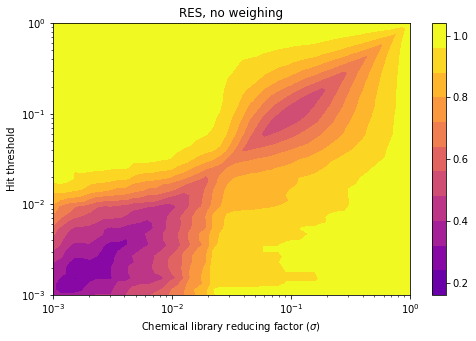

In [7]:
res_nw.plot(title="RES, no weighing")

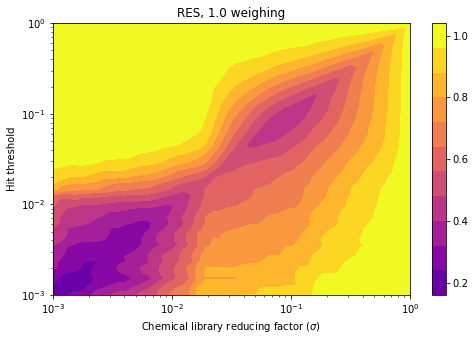

In [8]:
res_exp1.plot(title="RES, 1.0 weighing")

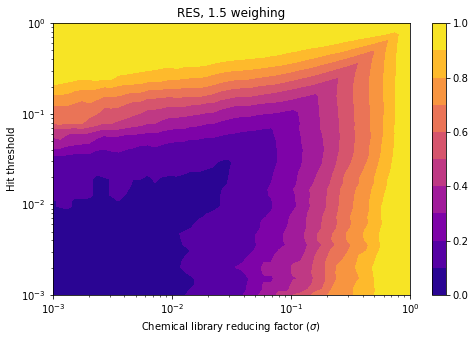

In [9]:
res_exp2.plot(title="RES, 1.5 weighing")

Text(0, 0.5, 'AUROC')

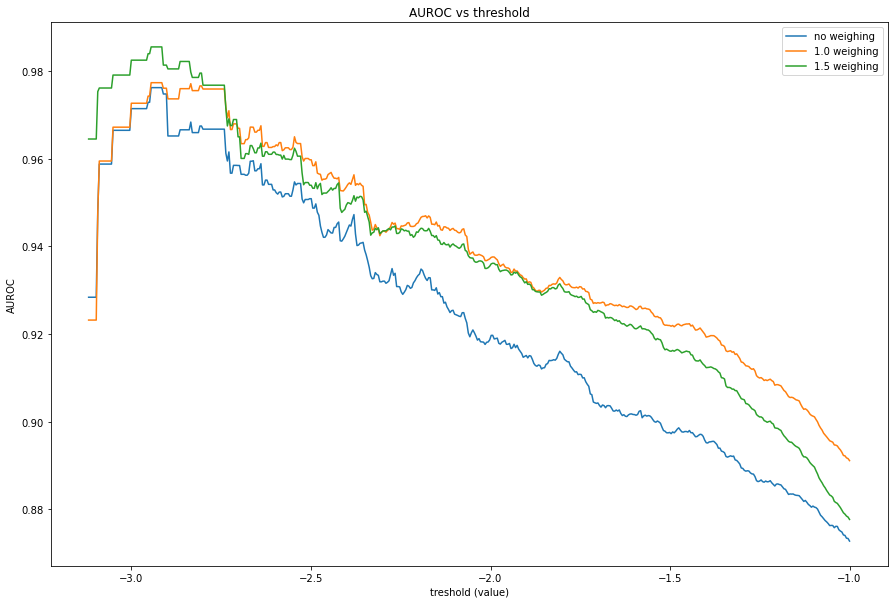

In [47]:
# Plot AUROC score as function of threshold value

# imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# make thresholds
# min_ = np.sort(df_true_nw)[0]+0.5
# max_ = np.sort(df_true_nw)[-1]
# max_ = -1
# thresholds = np.linspace(min_, max_, 500)
# thresholds = np.logspace(-3, 0, 100)

# calculate auroc as function of threshold
# mm = MinMaxScaler()

pct_scale = False

if pct_scale is False:
    min_ = np.sort(df_true_nw)[0]+0.5
    max_ = np.sort(df_true_nw)[-1]
    max_ = -1
    thresholds = np.linspace(min_, max_, 500)
    
    aurocs_nw = [roc_auc_score(df_true_nw > threshold, df_pred_nw) for threshold in thresholds]
    aurocs_exp1 = [roc_auc_score(df_true_exp1 > threshold, df_pred_exp1) for threshold in thresholds]
    aurocs_exp2 = [roc_auc_score(df_true_exp2 > threshold, df_pred_exp2) for threshold in thresholds]

else:
    min_ = 0.00
    max_ = 1
    thresholds = np.logspace(-3, -0.0001, 500)
    aurocs_nw = [roc_auc_score(df_true_nw > np.percentile(df_true_nw, threshold*100), df_pred_nw) for threshold in thresholds]
    aurocs_exp1 = [roc_auc_score(df_true_exp1 > np.percentile(df_true_exp1, threshold*100), df_pred_exp1) for threshold in thresholds]
    aurocs_exp2 = [roc_auc_score(df_true_exp2 > np.percentile(df_true_exp2, threshold*100), df_pred_exp2) for threshold in thresholds]


    
# plot
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(thresholds, aurocs_nw, label="no weighing")
plt.plot(thresholds, aurocs_exp1, label="1.0 weighing")
plt.plot(thresholds, aurocs_exp2, label="1.5 weighing")
plt.legend()

if pct_scale is True:
    plt.xscale("log")
    plt.xlabel("threshold (pct)")
else:
    plt.xlabel("treshold (value)")
plt.title("AUROC vs threshold")
plt.ylabel("AUROC")

/opt/anaconda3x/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3x/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Text(0, 0.5, 'F-1 Score')

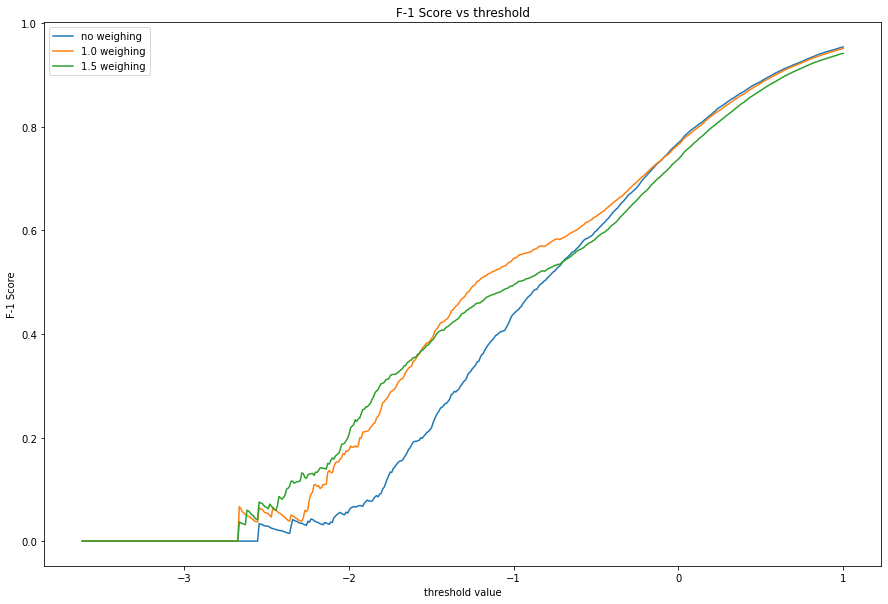

In [33]:
# Plot F1-score as function of threshold value
# make thresholds


pct_scale = False

if pct_scale is False:
    min_ = np.sort(df_true_nw)[0]
    max_ = np.sort(df_true_nw)[-1]
    max_ = 1
    thresholds = np.linspace(min_, max_, 500)

    # calculate F1 as function of threshold
    scores_nw = [f1_score(df_true_nw < threshold, df_pred_nw < threshold) for threshold in thresholds]
    scores_exp1 = [f1_score(df_true_exp1 < threshold, df_pred_exp1 < threshold) for threshold in thresholds]
    scores_exp2 = [f1_score(df_true_exp2 < threshold, df_pred_exp2 < threshold) for threshold in thresholds]
    
else:
    thresholds = np.logspace(-3, -0.0001, 500)
    scores_nw = [f1_score(df_true_nw < np.percentile(df_true_nw, threshold*100), df_pred_nw < np.percentile(df_true_nw, threshold)) for threshold in thresholds]
    scores_nw = [f1_score(df_true_exp1 < np.percentile(df_true_exp1, threshold*100), df_pred_exp1 < np.percentile(df_true_nw, threshold)) for threshold in thresholds]
    scores_nw = [f1_score(df_true_exp2 < np.percentile(df_true_exp2, threshold*100), df_pred_exp2 < np.percentile(df_true_nw, threshold)) for threshold in thresholds]


# plot
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(thresholds, scores_nw, label="no weighing")
plt.plot(thresholds, scores_exp1, label="1.0 weighing")
plt.plot(thresholds, scores_exp2, label="1.5 weighing")
plt.legend()
plt.title("F-1 Score vs threshold")
if pct_scale is False:
    plt.xlabel("threshold (value)")
else:
    plt.xscale("log")
    plt.xlabel("threshold (pct)")
plt.ylabel("F-1 Score")

## 2. GIN

We now analyze the Graph Attention Model (https://arxiv.org/abs/1810.00826). In all three cases, the model was trained based on early stopping heuristics. Though formal hyperparameter search has not been conducted, each model is trained to reasonable convergence values. 

In [12]:
# Read and format relevant data
df_true_nw = pd.read_csv("../outputs/GINREGv0.1_exp0_labels.csv", header=None)
df_pred_nw = pd.read_csv("../outputs/GINREGv0.1_exp0_preds.csv", header=None)

df_true_exp1 = pd.read_csv("../outputs/GINREGv0.1_exp1.0_labels.csv", header=None)
df_pred_exp1 = pd.read_csv("../outputs/GINREGv0.1_exp1.0_preds.csv", header=None)

df_true_exp2 = pd.read_csv("../outputs/GINREGv0.1_exp1.5_labels.csv", header=None)
df_pred_exp2 = pd.read_csv("../outputs/GINREGv0.1_exp1.5_preds.csv", header=None)

df_true_nw = np.array(df_true_nw).flatten()
df_pred_nw = np.array(df_pred_nw).flatten()

df_true_exp1 = np.array(df_true_exp1).flatten()
df_pred_exp1 = np.array(df_pred_exp1).flatten()

df_true_exp2 = np.array(df_true_exp2).flatten()
df_pred_exp2 = np.array(df_pred_exp2).flatten()

print(df_true_nw.dtype, df_true_nw.shape)
print(df_pred_nw.dtype, df_pred_nw.shape)

print(df_true_exp1.dtype, df_true_exp1.shape)
print(df_pred_exp1.dtype, df_pred_exp1.shape)

print(df_true_exp2.dtype, df_true_exp2.shape)
print(df_pred_exp2.dtype, df_pred_exp2.shape)

float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)
float64 (42048,)


(-4.0, 10.0)

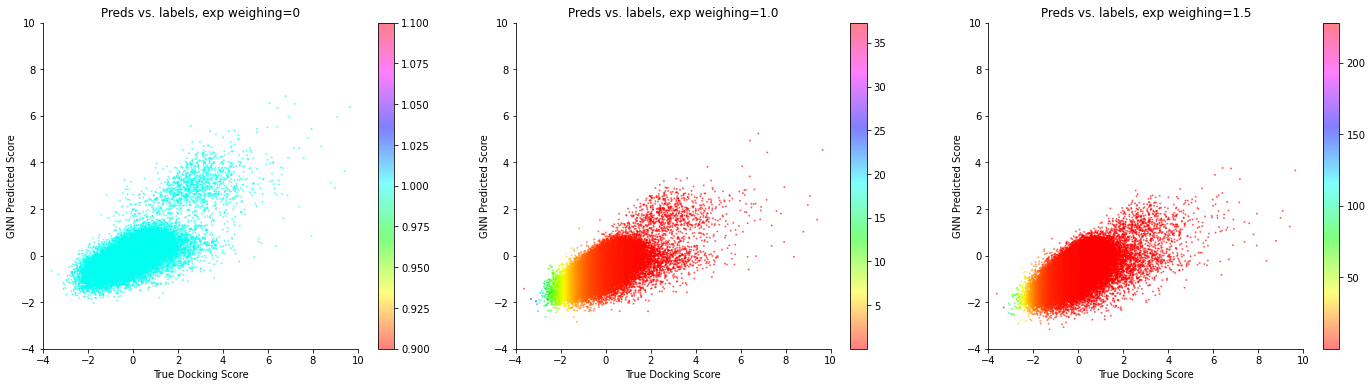

In [14]:
# Plot preds vs true labels

plt.rcParams['figure.figsize'] = [24, 6]

# no weighing 
plt.subplot(1, 3, 1)
plt.scatter(df_true_nw, df_pred_nw, s=1, alpha=0.5, c=np.ones((df_true_nw.shape)), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.0
plt.subplot(1, 3, 2)
plt.scatter(df_true_exp1, df_pred_exp1, s=1, alpha=0.5, c=np.exp(-1*df_true_exp1), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.5
plt.subplot(1, 3, 3)
plt.scatter(df_true_exp2, df_pred_exp2, s=1, alpha=0.5, c=np.exp(-1.5*df_true_exp2), cmap='hsv')
plt.colorbar()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.5")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

(-4.0, 10.0)

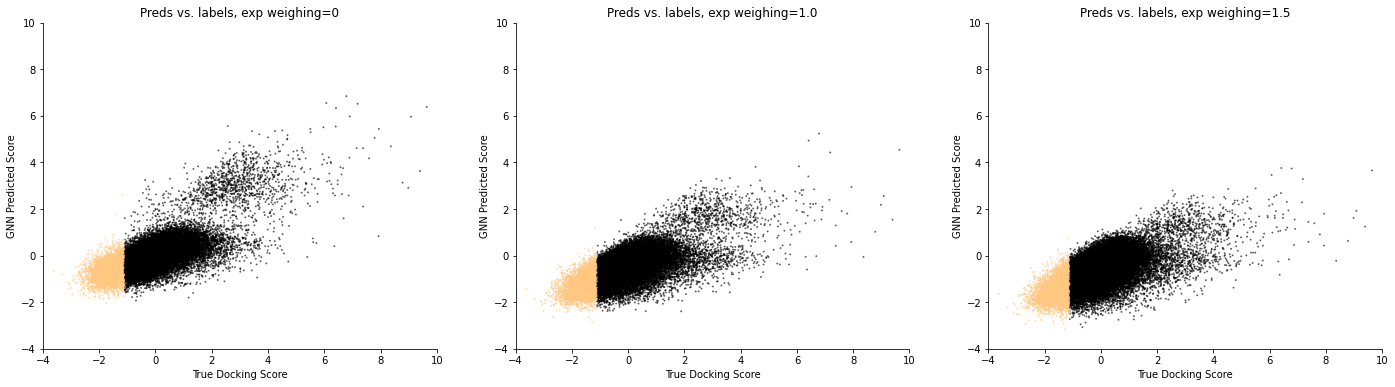

In [15]:
# Replot scatter plots but with hard threshold coloring
threshold_color_pct = 10
threshold_color = np.sort(df_true_nw)[int(df_true_nw.shape[0]/threshold_color_pct)]

f_nw = df_true_nw

# no weighing
plt.subplot(1, 3, 1)
plt.scatter(df_true_nw, df_pred_nw, s=1, alpha=0.5, c=(df_true_nw < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.0
plt.subplot(1, 3, 2)
plt.scatter(df_true_exp1, df_pred_exp1, s=1, alpha=0.5, c=(df_true_exp1 < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.0")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

# exp=1.5
plt.subplot(1, 3, 3)
plt.scatter(df_true_exp2, df_pred_exp2, s=1, alpha=0.5, c=(df_true_exp1 < threshold_color), cmap='copper')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel("True Docking Score")
plt.ylabel("GNN Predicted Score")
plt.title("Preds vs. labels, exp weighing=1.5")
plt.xlim(-4, 10)
plt.ylim(-4, 10)

In [16]:
# Regression detection heat maps -- TODO: clean code


"""Main module."""
import matplotlib.pyplot as plt
import numpy as np


def erf(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return len(
        set(indexs_pred[:int(r * indexs_pred.shape[0])]).intersection(set(indexs_true[:int(y * indexs_pred.shape[0])])))


def erfmax(x_pred, x_true, r, y, indexs_pred, indexs_true):
    return (int(min(r, y) * indexs_pred.shape[0]))


def nefr(*i):
    return erf(*i) / erfmax(*i)


def nefrcurve(points_, p, t, min_sample=-3, reverse_sort=False):
    xs = np.logspace(min_sample, 0, points_, base=10)
    ys = np.logspace(min_sample, 0, points_, base=10)

    indexs_pred = np.argsort(p)
    indexs_true = np.argsort(t)
    if reverse_sort:
        indexs_pred = indexs_pred[::-1]
        indexs_true = indexs_true[::-1]

    xx, yy = np.meshgrid(xs, ys)
    zz = np.zeros(xx.shape)
    for i in range(points_):
        for j in range(points_):
            zz[i, j] = nefr(p, t, xx[i, j], yy[i, j], indexs_pred, indexs_true)

    return xx, yy, zz


class RegressionEnrichmentSurface:

    def __init__(self, percent_min=-3):
        self.min = percent_min
        self.nefr = None
        self.stratify = False

    def compute(self, trues, preds, stratify=None, samples=30):
        self.stratify = stratify is not None
        self.samples = samples
        if not self.stratify:
            self.nefr = nefrcurve(samples, preds, trues, self.min)
        else:
            x, y, z = [], [], []
            u, indices = np.unique(stratify, return_inverse=True)
            for i in (range(u.shape[0])):
                locs = np.argwhere(indices == i).flatten()
                preds_strat = preds[locs]
                trues_strat = trues[locs]
                try:
                    x_2, y_2, z_2 = nefrcurve(samples, preds_strat, trues_strat)
                except ZeroDivisionError:
                    continue
                x.append(x_2)
                y.append(y_2)
                z.append(z_2)
            self.nefr = (x, y, z)

        return self.nefr

    def compute_integral(self, uselog=True):
        import scipy.integrate
        assert not self.stratify  # not implemented yet

        X, Y, Z = self.nefr[0], self.nefr[1], self.nefr[2]
        if uselog:
            Y = np.log(Y[:self.samples, 0].flatten())
            X = np.log(X[0, :self.samples].flatten())
            Y /= np.abs(Y.min())
            X /= np.abs(X.min())

        result = scipy.integrate.simps(scipy.integrate.simps(Z, Y), X)
        return result

    def plot(self, save_file=None, levels=10, title="RES", cmap='plasma', figsize=(8, 5)):
        plt.figure(figsize=figsize)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Chemical library reducing factor ($\sigma$)")
        plt.ylabel("Hit threshold")
        plt.contourf(np.stack(self.nefr[0]).mean(0) if self.stratify else self.nefr[0],
                     np.stack(self.nefr[1]).mean(0) if self.stratify else self.nefr[1],
                     np.stack(self.nefr[2]).mean(0) if self.stratify else self.nefr[2],
                     vmin=0,
                     vmax=1,
                     cmap=cmap,
                     levels=levels)

        plt.colorbar(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.title(title)

        if save_file is None:
            plt.show()
        else:
            plt.savefig(save_file, bbox_inches='tight', dpi=300)

In [17]:
res_nw = RegressionEnrichmentSurface(-3)
res_nw.compute(df_true_nw * -1, df_pred_nw * -1, samples=50)

res_exp1 = RegressionEnrichmentSurface(-3)
res_exp1.compute(df_true_exp1 * -1, df_pred_exp1 * -1, samples=50)

res_exp2 = RegressionEnrichmentSurface(-3)
res_exp2.compute(df_true_exp2 * -1, df_pred_exp2 * -1, samples=50)

(array([[0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        ...,
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ],
        [0.001     , 0.0011514 , 0.00132571, ..., 0.75431201, 0.86851137,
         1.        ]]),
 array([[0.001     , 0.001     , 0.001     , ..., 0.001     , 0.001     ,
         0.001     ],
        [0.0011514 , 0.0011514 , 0.0011514 , ..., 0.0011514 , 0.0011514 ,
         0.0011514 ],
        [0.00132571, 0.00132571, 0.00132571, ..., 0.00132571, 0.00132571,
         0.00132571],
        ...,
        [0.75431201, 0.75431201, 0.75431201, ..., 0.75431201, 0.75431201,
         0.75431201],
        [0.8

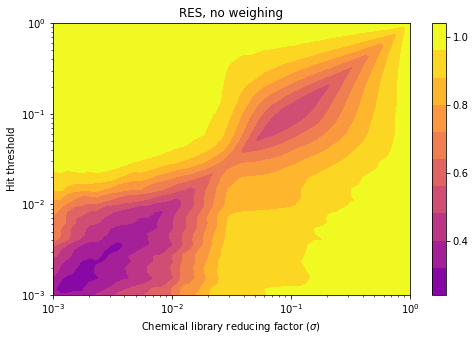

In [18]:
res_nw.plot(title="RES, no weighing")

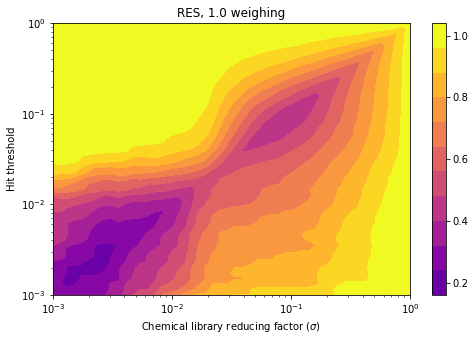

In [19]:
res_exp1.plot(title="RES, 1.0 weighing")

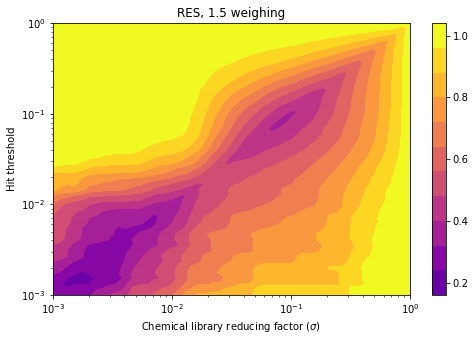

In [20]:
res_exp2.plot(title="RES, 1.5 weighing")

Text(0, 0.5, 'AUROC')

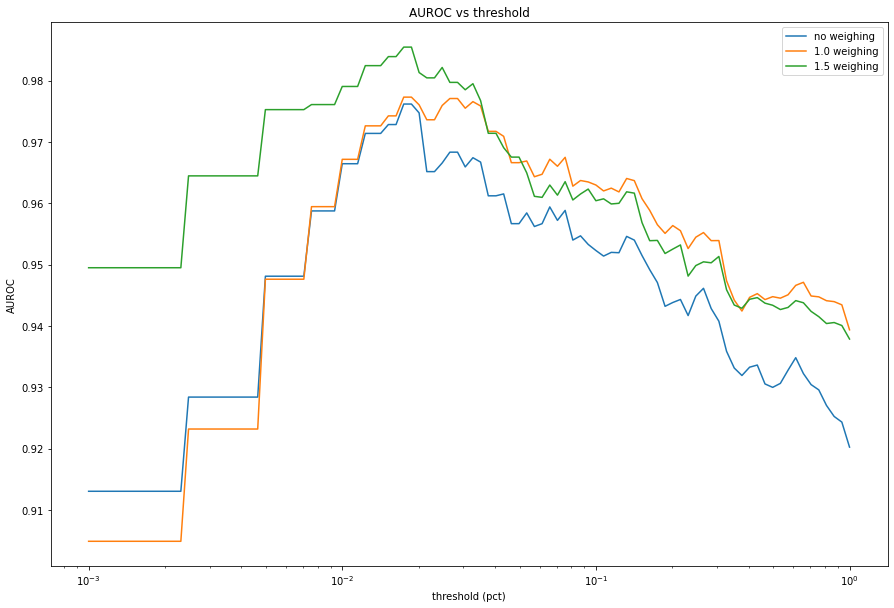

In [33]:
# Plot AUROC score as function of threshold value

# imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# make thresholds
# min_ = np.sort(df_true_nw)[0]+0.5
# max_ = np.sort(df_true_nw)[-1]
# max_ = 2
# thresholds = np.linspace(min_, max_, 500)
thresholds=np.logspace(-3, 0, 100)

# calculate auroc as function of threshold
mm = MinMaxScaler()

df_pred_nw_scaled = mm.fit_transform(df_pred_nw.reshape((-1,1))).flatten()
aurocs_nw = [roc_auc_score(df_true_nw > np.percentile(df_true_nw, threshold), df_pred_nw_scaled) for threshold in thresholds]

df_pred_exp1_scaled = mm.fit_transform(df_pred_exp1.reshape((-1,1))).flatten()
aurocs_exp1 = [roc_auc_score(df_true_exp1 > np.percentile(df_true_exp1, threshold), df_pred_exp1_scaled) for threshold in thresholds]

df_pred_exp2_scaled = mm.fit_transform(df_pred_exp2.reshape((-1,1))).flatten()
aurocs_exp2 = [roc_auc_score(df_true_exp2 > np.percentile(df_true_exp2, threshold), df_pred_exp2_scaled) for threshold in thresholds]


# plot
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(thresholds, aurocs_nw, label="no weighing")
plt.plot(thresholds, aurocs_exp1, label="1.0 weighing")
plt.plot(thresholds, aurocs_exp2, label="1.5 weighing")
plt.legend()
plt.xscale("log")
plt.title("AUROC vs threshold")
plt.xlabel("threshold (pct)")
plt.ylabel("AUROC")

/opt/anaconda3x/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3x/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/opt/anaconda3x/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Text(0, 0.5, 'F-1 Score')

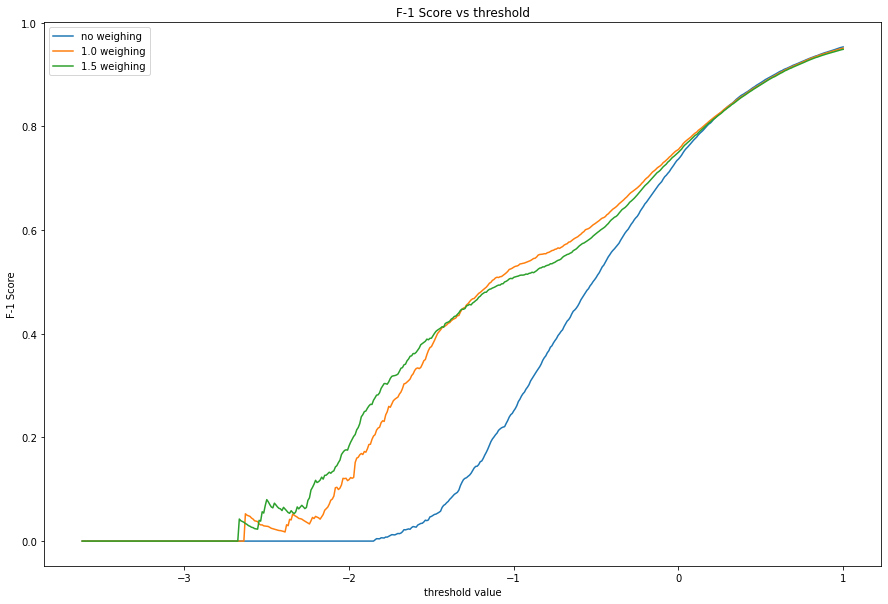

In [22]:
# Plot F1-score as function of threshold value
# make thresholds
min_ = np.sort(df_true_nw)[0]
max_ = np.sort(df_true_nw)[-1]
max_ = 1
thresholds = np.linspace(min_, max_, 500)

# calculate F1 as function of threshold
scores_nw = [f1_score(df_true_nw < threshold, df_pred_nw < threshold) for threshold in thresholds]
scores_exp1 = [f1_score(df_true_exp1 < threshold, df_pred_exp1 < threshold) for threshold in thresholds]
scores_exp2 = [f1_score(df_true_exp2 < threshold, df_pred_exp2 < threshold) for threshold in thresholds]

# plot
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(thresholds, scores_nw, label="no weighing")
plt.plot(thresholds, scores_exp1, label="1.0 weighing")
plt.plot(thresholds, scores_exp2, label="1.5 weighing")
plt.legend()
plt.title("F-1 Score vs threshold")
plt.xlabel("threshold value")
plt.ylabel("F-1 Score")